In [92]:
%load_ext autoreload
## Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
## Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [94]:
## Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

### Imports

In [95]:
import sys
coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)

In [96]:
import time
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import processor, util
from coffea.nanoevents import NanoAODSchema, BaseSchema

import numpy as np
from numpy.random import RandomState
import importlib

# import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import hist

from plotters.pltStyle import pltStyle
pltStyle(style='hep')
# pltStyle(style='paper')
plt.rcParams['figure.dpi'] = 150
import os

### import subpackages
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import save_data, read_data, get_median, gauss, slice_histogram, add_flavors
from plotters.plotters import plot_response_dist, plot_corrections, plot_corrections_eta

from helpers import rebin_hist, mirror_eta_to_plus, sum_neg_pos_eta, find_ttbar_xsec
# %matplotlib notebook 

### Parameters of the run

In [97]:
UsingDaskExecutor = False
CERNCondorCluster = True
CoffeaCasaEnv     = False
load_preexisting  = False    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True   ### True if run only on one file and five chuncs to debug processor
load_fit_res      = False   ### True if only replot the fit results

fine_etabins      = False   ### Don't merge eta bins together when fitting responses. Preprocessing always done in many bins
one_bin           = False   ### Unite all eta and pt bins in one

Nfiles = -1                 ### -1 for all files

tag_Lx = '_L5'                 ### L5 or L23, but L23 not supported since ages.

### tag for the dataset used
data_tag = 'DY-MG-Py' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip'
data_tag = 'DY-FxFx'
### name of the specific run if parameters changed
add_tag = ''  

certificate_dir = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

### Dataset parameters

In [98]:
dataset = None
fileslist = None

dataset_dictionary = {
    "Pythia-TTBAR": 'fileNames/TTToSemi20UL18_JMENano.txt',
    "Herwig-TTBAR": 'fileNames/TTbar_Herwig_20UL18_JMENano.txt',
    "DY-MG-Py":     'fileNames/DYJets_MG-Py.txt',
    "DY-MG-Her":    'fileNames/DYJets_MG-Her.txt',
    "QCD-MG-Py":    'fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt',
    "QCD-MG-Her":   'fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt',
    "QCD-Py":       'fileNames/QCD20UL18_JMENano.txt',
    "DY-FxFx":      'fileNames/DYJets.txt',
}

if not (fileslist is None):
    print(f'A specific filelist specified. The calculation will be run on the files {filelist}')
elif data_tag in dataset_dictionary.keys():
    dataset = dataset_dictionary[data_tag]
    print(f'The data tag "{data_tag}" found in the dataset_dictionary. The dataset "{dataset}" will be used.')
elif not(dataset is None):
    print(f'Using the provided dataset "{dataset}" and the data tag "{data_tag}".')
else:
    raise ValueError(f'The data tag "{data_tag}" not found in the dataset_dictionary and no dataset provided.')

The data tag "DY-FxFx" found in the dataset_dictionary. The dataset "fileNames/DYJets.txt" will be used.


In [99]:
### Choose the correct redirector
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
## assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

In [100]:
#Import the correct processor
Processor = importlib.import_module('CoffeaJERCProcessor'+tag_Lx).Processor

tag_full = tag_Lx+'_'+data_tag+add_tag
if test_run:
    tag_full = tag_full+'_test'
outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'

tag_fit_res = tag_full

if fine_etabins:
    tag_fit_res=tag_full+'_fine_etaBins'

if one_bin:
    tag_fit_res=tag_fit_res+'_oneBin'
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if not os.path.exists("fig"):
    os.mkdir("fig/")
    os.mkdir("fig/responses/")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")
    
maxchunks = 5 if test_run else None
if test_run:
    Nfiles = 1

print(f'Running on the number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}')


Running on the number of files: 1
 Job with the full tag _L5_DY-FxFx_test
 Outname = out/CoffeaJERCOutputs_L5_DY-FxFx_test.coffea


### For the attempt to correctly combine three ttbar channels. Not fully tested

In [101]:
def txt2filesls(dataset_name):
    with open(dataset_name) as f:
        rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
    return fileslist

In [102]:
combineTTbar = False
ttbar_tags = ['Semi', 'Dilep', 'Had']

filesets = {}
if not (fileslist is None):
    xsec_dict = {'dataset1': 1}
    filesets = {'dataset1': {"files": fileslist, "metadata": {"xsec": 1}}}
elif combineTTbar:
    for ftag in ttbar_tags:
        data_name = f'fileNames/fileNames_TTTo{ftag}20UL18_JMENano.txt'
        fileslist = txt2filesls(data_name)[:Nfiles]
        xsec = find_ttbar_xsec(data_name)
        filesets[ftag] = {"files": fileslist, "metadata": {"xsec": xsec}}
elif "QCD-MG" in data_tag:
    ### if dataset striched together from a set of datasets where the cross-section for each is given in `dataset`
    dataset_path = '/'.join(dataset.split('/')[:-1])
    with open(dataset) as f:
        lines = f.readlines()
    lines_split = [line.split() for line in lines]
    xsec_dict = {lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    file_dict = {lineii[1]: lineii[0] for lineii in lines_split }
    for key in file_dict.keys():
        data_name = file_dict[key]
        fileslist = txt2filesls(dataset_path+'/'+data_name)[:Nfiles]
        filesets[key] = {"files": fileslist, "metadata": {"xsec": xsec_dict[key]}}
    if test_run:
        filesets = {key: filesets[key] for key in list(filesets.keys())[:3]}      
else:
    fileslist = txt2filesls(dataset)[:Nfiles]
    #### If manyally adding fileslist
    xsec_dict = {'dataset1': 1}
    filesets = {'dataset1': {"files": fileslist, "metadata": {"xsec": 1}}}


Test if certificate works to open the file

In [103]:
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = certificate_dir
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

env_extra = [
            f'export X509_USER_PROXY={certificate_dir}',
            f'export X509_CERT_DIR={certificate_dir}',
        ]

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [104]:
import uproot
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

# print(f"The test file read successfully. All good with certifiates.")

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Dask+Condor setup on lxplus
#### 1.) The wrapper needs to be installed following https://github.com/cernops/dask-lxplus
#### 2.) Source lcg environment in bash
#### `source /cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/latest/x86_64-centos7-gcc11-opt/setup.sh`
#### Singularity could work but not confirmed.
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [105]:
 # Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    from dask.distributed import Client 
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [106]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
 # Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
#             env_extra=env_extra,
            cores = 1,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
                'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=200)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag_Lx+'.py')
    client.upload_file('count_2d.py')

    client

### Run the processor

In [107]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
chunksize = 10000
# maxchunks = 20

if not load_preexisting:
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 2,
#                                               'workers': 2
                                          },
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)

#### Attempt to prevent the error when the cluster closes. Doesn't always work.
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

Output()

evaluator =  <coffea.lookup_tools.evaluator.evaluator object at 0x7f52c2eed2b0>
evaluator keys =  dict_keys(['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs'])


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipywidgets/wid
gets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use 
.get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipywidgets/wid
gets/widget_output.py:112: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use 
.get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

Output()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipywidgets/wid
gets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use 
.get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipywidgets/wid
gets/widget_output.py:112: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use 
.get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

Processor finished. Time elapsed:  24.096303701400757
Saving the output histograms under:  out/CoffeaJERCOutputs_L5_DY-FxFx_test.coffea


In [108]:
allflav = [key for key in output.keys() if 'ptresponse' in key]

In [109]:
output

{'dataset1': {'ptresponse_b': Hist(
    Variable(array([   15.,    17.,    20.,    23.,    27.,    30.,    35.,    40.,
            45.,    57.,    72.,    90.,   120.,   150.,   200.,   300.,
           400.,   550.,   750.,  1000.,  1500.,  2000.,  2500.,  3000.,
          3500.,  4000.,  4500.,  5000., 10000.]), name='pt_gen', label='$p_{T,gen}$'),
    Regular(100, 0, 2.5, name='ptresponse', label='RECO / GEN response'),
    Variable(array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839,
         -3.664, -3.489, -3.314, -3.139, -2.964, -2.853, -2.65 , -2.5  ,
         -2.322, -2.172, -2.043, -1.93 , -1.83 , -1.74 , -1.653, -1.566,
         -1.479, -1.392, -1.305, -1.218, -1.131, -1.044, -0.957, -0.879,
         -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
         -0.087,  0.   ,  0.087,  0.174,  0.261,  0.348,  0.435,  0.522,
          0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
          1.305,  1.392,  1.479,  1.566,  1.653,  

In [110]:
5299+5156
1874+1851
1811+1746
2969+2863

10455

3725

3557

5832

In [112]:
# output['ptresponse_b'].sum().value

In [113]:
# # [output[key].sum().value for key in allflav]
# for key in allflav:
#     print(key, ' = ', output[key].sum().value)

In [114]:
# sum([output[key].sum().value for key in allflav])

In [115]:
# 36959+37286

In [116]:
# output['ptresponse_unmatched'].sum()
# output['cutflow']['iso jets']

### Striching up the sample

In [117]:
output_orig = output
if "QCD-MG" in data_tag:
    response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
    scale_factors = hist_div(xsec_dict, response_sums)
    all_histo_keys = output[next(iter(output.keys()))].keys()
    result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
    output = result
elif len(output.keys())==1:
    output = output[list(output.keys())[0]]

### Fit responses

Define some global variables for the fit

In [118]:
## find the first response histogram to extract the axes
for key in output.keys():
    if 'response' in key:
        response_key = key
        break

if fine_etabins==True:
    tag_full = tag_full+'_fineeta'
    ptbins = output[response_key].axes["pt_gen"].edges 
    ptbins_c = output[response_key].axes['pt_gen'].centers
#     ptbins = np.array([15, 40, 150, 400, 4000, 10000])
#     ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output[response_key].axes["jeteta"].edges #output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
#     etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output[response_key].axes["pt_gen"].edges 
#     ptbins = ptbins[2:] #because there is a pt cut on pt gen and no point of fitting and plotting below that
    ptbins_c = output[response_key].axes['pt_gen'].centers
    etabins = np.array([-5.191, -3.489, -3.139, -2.853,   -2.5, -2.322,  -1.93, -1.653, -1.305, -0.783,      0,  0.783,  1.305,  1.653,   1.93,  2.322,    2.5,  2.853,  3.139,  3.489, 5.191])
#     etabins = np.array([-5.191, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5.191])
    etabins = np.array([-5.191, -3.139, -2.5, -1.305, 0., 1.305, 2.5, 3.139, 5.191])
    

    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

# ptresp_edd = output[response_key].axes['ptresponse'].edges
# plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]

#### Testing adding ttbar hists
##### To do: replace to the system done with `sum_subhist`

In [119]:
# combineTTbar = False
if combineTTbar:
    ids = output[list(output.keys())[0]].axis('dataset').identifiers()
    names = [idii.name for idii in ids  ]

    output_comb = {}

    N = {}
    for s in names:
        N[s] = output['cutflow'][s+': all events']
    N_av = sum(N.values())/3

    for key in output.keys():
        if key!='cutflow':
            hist_comb = output[key].integrate('dataset', ids[0])
            hist_comb.scale(find_ttbar_xsec(names[0])*N[names[0]]/N_av)
            for ii in range(1,len(ids)-1):
                hist2 = output[key].integrate('dataset', ids[ii])
                hist2.scale(find_ttbar_xsec(ids[ii].name)*N[names[ii]]/N_av)
                hist_comb = hist_comb+hist2
            output_comb[key] = hist_comb
        else:
            cut_keys = list(output[key].keys())
            len_new_keys = len(cut_keys)//3
            output_comb["cutflow"] = {}
            for cut in range(len_new_keys):
                output_comb["cutflow"]["Inclusive"+cut_keys[cut][4:]] = (output[key][cut_keys[cut]]*find_ttbar_xsec(names[0])*N[names[0]]/N_av +
                                                               output[key][cut_keys[cut+len_new_keys]]*find_ttbar_xsec(names[1])*N[names[1]]/N_av +
                                                               output[key][cut_keys[cut+2*len_new_keys]]*find_ttbar_xsec(names[2])*N[names[2]]/N_av 
                                                              )
                
    output = output_comb
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [120]:
def fit_response(xvals, yvals, Neff):
    if_failed = False
    
    # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
    # so changing limits to match the both cases
    if (np.sum(yvals)-Neff)/Neff<1e-5:
        N_min_limit=50
    else:
        N_min_limit=15
    
    nonzero_bins = np.sum(yvals>0)
    if nonzero_bins<2 or Neff<N_min_limit:
        p2=[0,0,0]
        chi2 = np.nan
        cov = np.array([[np.nan]*3]*3)
        Ndof = 0
    #                 print("Too little data points, skipping p = ", p2)
    else:
        try:
            p, cov = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                 ######## Second Gaussian ########
            xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
            xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
            xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
    #                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

            if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
                if len(range(xfit_l,xfit_h))<6:
                    xfit_l = xfit_l-1
                    xfit_h = xfit_h+1
            if xfit_l<0:
                xfit_h-=xfit_l
                xfit_l = 0
            xvals2 = xvals[xfit_l: xfit_h]
            yvals2 = yvals[xfit_l: xfit_h]
    #                     if ptBin.lo>290:
    #                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
    #                         print("yvals = ", yvals)
    #                         print("yvals2 = ", yvals2)
            p2, cov = curve_fit(gauss, xvals2, yvals2, p0=p)
                         ######## End second Gaussian ########

            ygaus = gauss(xvals, *p2)
            chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
            Ndof = len(xvals2)-3
    #                     if chi2<50000:
    #                         pass
    #                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
    #                     else:
    #                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
        except(RuntimeError):   #When fit failed
            p2=[0,0,0]
    #                     print("Fit failed because of non-convergance, p = ", p2)
            chi2 = np.nan
            cov = np.array([[np.nan]*3]*3)
            Ndof = 0
            if_failed = True
            
    return [p2, cov, chi2, Ndof, if_failed]

In [121]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad

def fit_responses(output, flavor='b'):
    warnings.filterwarnings('ignore')
    saveplots = True
    if test_run or fine_etabins:
        saveplots = False
    saveplots = False
        
    response_hist, recopt_hist = add_flavors(output, flavor, combine_antiflavour)
    
    response_hist = rebin_hist(response_hist, 'jeteta' , etabins)
    recopt_hist = rebin_hist(recopt_hist, 'jeteta' , etabins)
    
    sum_neg_pos_eta_bool=True
    if sum_neg_pos_eta_bool==True:
        response_hist = sum_neg_pos_eta(response_hist)
        recopt_hist = sum_neg_pos_eta(recopt_hist)
        
    results = {key:np.zeros((jetpt_length, jeteta_length))
                  for key in ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"]  }
                            
    N_converge = 0
    N_not_converge = 0

    FitFigDir1 = 'fig/responses/responses'+tag_full
    if saveplots and not os.path.exists(FitFigDir1):
        os.mkdir(FitFigDir1)
    
    FitFigDir = FitFigDir1+'/response_pt_eta'+flavor+tag_full
    if saveplots and not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        print("Response fits will be saved under ", FitFigDir)
    elif not saveplots:
        print("Response fits won't be saved")

    xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
    response_edges = response_hist.axes['ptresponse'].edges[1:]

    for i in range(jetpt_length):
        pt_lo = ptbins[i]
        pt_hi = ptbins[i+1]
    #         print('-'*25)

        if not np.isinf(pt_hi):
            pt_string = '_pT'+str(int(pt_lo))+'to'+str(int(pt_hi))
        else:
            pt_string = '_pT'+str(pt_lo) + 'to' + str(pt_hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            histo = response_hist[i, :, k]
            histopt = recopt_hist[i, k]
            
            etaPl_lo = etabins[k+jeteta_length]
            etaPl_hi = etabins[k+1+jeteta_length]
            eta_string = '_eta'+str(etaPl_lo)+'to'+str(etaPl_hi)
            eta_string = eta_string.replace('.','')
            
#             histo, histopt, eta_string = slice_histogram(response_hist, recopt_hist, etabins, k, pt_lo, pt_hi)
            yvals = histo.values()[1:]     #[1:] to exclude the second peak for low pt
            try:
                Neff = histo.sum().value**2/(histo.sum().variance)
            except ZeroDivisionError:
                Neff = histo.sum().value**2/(histo.sum().variance+1e-11)

            median, medianstd = get_median(xvals, yvals, response_edges, Neff)
            
            ##################### Mean of the pt_reco  ######################
            ### (The mean includes events that potentially had ptresponse in the second peak at low pt)
            ### No way to distinguish it if only x*weights are saved instead of the whole histogram.
            mean_reco_pt = histopt.value/np.sum(histo.values())
            
            ####################### Fitting ############################
            p2, cov, chi2, Ndof, if_failed = fit_response(xvals, yvals, Neff)
            if if_failed:
                N_not_converge += 1
            else:
                N_converge += 1
            
            results["Mean"][i,k] = p2[1]
            results["MeanVar"][i,k] = cov[1,1]
            results["Median"][i,k] = median
            results["MedianStd"][i,k] = medianstd
            results["MeanRecoPt"][i,k] = mean_reco_pt
    #             chi2s[i,k] = chi2

    ####################### Plotting ############################
            if  saveplots:
                figName = FitFigDir+'/ptResponse'+pt_string+eta_string
                plot_response_dist(histo, xvals, p2, cov, chi2, Ndof, median, medianstd, Neff, figName)              

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return results  

### Run fitting for each sample

In [122]:
medians = []
medianstds = []

-------------------------
-------------------------
Starting to fit each flavor in: ['unmatched']
-------------------------
-------------------------
Fitting flavor:  unmatched
Response fits won't be saved
N converge =  98 N_not_converge =  14
Figure saved: fig/corr_vs_pt/DY-FxFx_test/corr_vs_pt_DY-FxFx_test_unmatched.pdf /.png


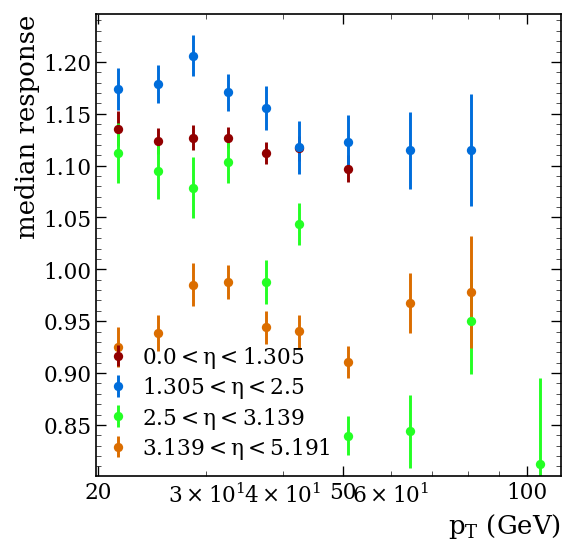

In [123]:
# %%time
# load_fit_res=False
combine_antiflavour = True
flavors = ['b', 'c', 'u', 'd', 's', 'g', 'q', 'ud', 'all', 'unmatched']
# flavors = ['unmatched']
print('-'*25)
print('-'*25)
print(f'Starting to fit each flavor in: {flavors}')
for flav in flavors:
    print('-'*25)
    print('-'*25)
    print('Fitting flavor: ', flav)
    if load_fit_res:
        result = {}
        keys = ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"] 
        for key in keys:
            result[key] = read_data(key, flav, tag_full)
    
    else:
        result = fit_responses(output, flav)
        medians.append(result["Median"][0][0])
        medianstds.append(result["MedianStd"][0][0])
        for key in result:
            save_data(result[key], key, flav, tag_full, ptbins, etabins_mod)
            pass
            
#     print("result = ", result)
    median = result["Median"]
    medianStd = result["MedianStd"]
    
    meanstd = np.sqrt(result["MeanVar"])
            
    if one_bin: #or fine_etabins:
        plot_corrections_eta(result["Median"], result["MedianStd"], ptbins, etabins_c, tag_full, flav)
    else:
        plot_corrections(result["Median"], result["MedianStd"], ptbins_c, etabins_mod, tag_full, flav)

In [124]:
# fit_responses(output, 'g')

In [125]:
print('-----'*10)
print("All done. Congrats!")

--------------------------------------------------
All done. Congrats!
